# COVID-19 in Manaus

# Analysis and Forecasting

This notebook was an exercise based on methodology from the book of Jason Brownlee, Introduction to Time Series Forecasting with Python.

In [116]:
# check the versions of key python libraries 

#import scipy
#print('scipy: %s' % scipy.__version__)

import numpy as np
print('numpy: %s' % np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)

import seaborn as sns
%matplotlib inline
print('seaborn: %s' % sns.__version__)

import pandas as pd
print('pandas: %s' % pd.__version__)
from pandas.plotting import autocorrelation_plot

import statsmodels
print('statsmodels: %s' % statsmodels.__version__) # scikit-learn

import sklearn
print('sklearn: %s' % sklearn.__version__)

from sklearn.metrics import mean_squared_error

from tqdm import tqdm
#import requests
import zipfile

import warnings
warnings.filterwarnings("ignore")

#import gc

!python --version


#pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)

numpy: 1.17.2
matplotlib: 3.1.1
seaborn: 0.9.0
pandas: 0.25.1
statsmodels: 0.10.1
sklearn: 0.21.3
Python 3.7.4


In [117]:
# original data files
data_dir = './data/'
data_zip = './data_zip/'

In [118]:
# download file
# source:
# https://www.kaggle.com/unanimad/corona-virus-brazil

print('downloading file .zip ...')
print()
!kaggle datasets download unanimad/corona-virus-brazil --force
print()
print('download finished!')
print()

with zipfile.ZipFile('corona-virus-brazil.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)
print('unziped!')

downloading file .zip ...

100%|████████████████████████████████████████| 871k/871k [00:00<00:00, 2.46MB/s]
100%|████████████████████████████████████████| 871k/871k [00:00<00:00, 2.45MB/s]

download finished!

unziped!


In [119]:
import os

#from datetime import date
#date_today = str(date.today())

if not os.path.exists(data_zip):
    os.mkdir(data_zip)
    print("Directory " , data_zip ,  " Created ")
else:    
    print("Directory " , data_zip ,  " already exists")
    
os.rename("./corona-virus-brazil.zip", data_zip+"corona-virus-brazil.zip")

Directory  ./data_zip/  already exists


In [120]:
print("Files:")
!ls {data_dir}

Files:
brazil_cities_coordinates.csv brazil_covid19_old.csv
brazil_covid19.csv            brazil_population_2019.csv
brazil_covid19_cities.csv     dataset.csv
brazil_covid19_macro.csv      validation.csv


In [121]:
covid_br = pd.read_csv(data_dir + 'brazil_covid19.csv')
print('Covid BR has {} rows and {} columns'.format(covid_br.shape[0], covid_br.shape[1]))
print()
print('Last information in ' + covid_br.iloc[-1,0])


Covid BR has 1680 rows and 5 columns

Last information in 2020-05-14


In [122]:
covid_br.head()

,date,region,state,cases,deaths
0,2020-02-26,Sudeste,São Paulo,1,0
1,2020-02-27,Sudeste,São Paulo,1,0
2,2020-02-28,Sudeste,São Paulo,1,0
3,2020-02-29,Sudeste,São Paulo,2,0
4,2020-03-01,Sudeste,São Paulo,2,0


In [123]:
covid_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 5 columns):
date      1680 non-null object
region    1680 non-null object
state     1680 non-null object
cases     1680 non-null int64
deaths    1680 non-null int64
dtypes: int64(2), object(3)
memory usage: 65.8+ KB


In [124]:
df = covid_br[covid_br["state"] == "Amazonas"]

df.tail(5)

,date,region,state,cases,deaths
1560,2020-05-10,Norte,Amazonas,12599,1004
1587,2020-05-11,Norte,Amazonas,12919,1035
1614,2020-05-12,Norte,Amazonas,14168,1098
1641,2020-05-13,Norte,Amazonas,15816,1160
1668,2020-05-14,Norte,Amazonas,17181,1235


In [125]:
df.shape

(61, 5)

In [126]:
df.describe()

,cases,deaths
count,61.000000,61.000000
mean,3401.426230,262.754098
std,4503.253137,353.073300
min,1.000000,0.000000
25%,151.000000,1.000000
50%,1484.000000,90.000000
75%,4801.000000,380.000000
max,17181.000000,1235.000000


### Feature Engineering

In [127]:


# datetime
df['date'] = pd.to_datetime(df['date'])

# day of week
df['day_of_week'] = df['date'].dt.day_name()
df['day_of_week_n'] = df['date'].dt.dayofweek  #Monday=0, Sunday=6.

# set index
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2020-03-15 to 2020-05-14
Data columns (total 6 columns):
region           61 non-null object
state            61 non-null object
cases            61 non-null int64
deaths           61 non-null int64
day_of_week      61 non-null object
day_of_week_n    61 non-null int64
dtypes: int64(3), object(3)
memory usage: 3.3+ KB


In [128]:
# creating month and day
df['month'] = [df.index[i].month for i in range(len(df))]
df['day'] = [df.index[i].day for i in range(len(df))] 

# creating death by day
df['deaths_d'] = df['deaths'] - df['deaths'].shift(1)



df.drop(['region'], axis = 1, inplace = True)
df.drop(['state'], axis = 1, inplace = True)
df.drop(['cases'], axis = 1, inplace = True)

# deleting "deaths = 0"
df = df[df["deaths"] > 0]

# week
df['week'] = [df.index[i].week for i in range(len(df))]
first_week = df.iloc[0, -1] 
df['week'] = df['week'].astype(int) - first_week +1 

df.head(2)


,deaths,day_of_week,day_of_week_n,month,day,deaths_d,week
date,,,,,,,
2020-03-25,1,Wednesday,2,3,25,1.0,1
2020-03-26,1,Thursday,3,3,26,0.0,1


## Data Analysis

### Components of Time Series

Time series analysis provides a body of techniques to better understand a dataset. Perhaps the most useful of these is the decomposition of a time series into 4 constituent parts:

- Level. The baseline value for the series if it were a straight line.

- Trend. The optional and often linear increasing or decreasing behavior of the series over time.
􏰀
- Seasonality. The optional repeating patterns or cycles of behavior over time.

- Noise. The optional variability in the observations that cannot be explained by the model.


p.11

### Concerns of Forecasting

When forecasting, it is important to understand your goal. Use the Socratic method and ask lots of questions to help zoom in on the specifics of your predictive modeling problem. For example:

1. How much data do you have available and are you able to gather it all together? More data is often more helpful, offering greater opportunity for exploratory data analysis, model testing and tuning, and model fidelity.

2. What is the time horizon of predictions that is required? Short, medium or long term? Shorter time horizons are often easier to predict with higher confidence.

3. Can forecasts be updated frequently over time or must they be made once and remain static? Updating forecasts as new information becomes available often results in more accurate predictions.

4. At what temporal frequency are forecasts required? Often forecasts can be made at a lower or higher frequencies, allowing you to harness down-sampling, and up-sampling of data, which in turn can offer benefits while modeling.


Time series data often requires cleaning, scaling, and even transformation. For example:

- Frequency. Perhaps data is provided at a frequency that is too high to model or is unevenly spaced through time requiring resampling for use in some models.

- Outliers. Perhaps there are corrupt or extreme outlier values that need to be identified and handled.

- Missing. Perhaps there are gaps or missing data that need to be interpolated or imputed.

p.12

______

- Sliding Window, p.15

- Sliding Window With Multivariates, p.16

- Sliding Window With Multiple Steps, p.18

- Lag Features, p.29: X.shift(1)

- Rolling Window Statistics, p.31: rolling(X).mean()

        width = 3
        shifted = temps.shift(width - 1)
        window = shifted.rolling(window=width)
        dataframe = concat([window.min(), window.mean(), window.max(), temps], axis=1) dataframe.columns = ['min', 'mean', 'max', 't+1']


- Expanding Window Statistics, p.33: expanding()

        temps = DataFrame(series.values)
        window = temps.expanding()
        dataframe = concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1) dataframe.columns = ['min', 'mean', 'max', 't+1']


### Summary Statistics

In [129]:
# Number of Observations
df.shape

(51, 7)

In [130]:
df.head()

,deaths,day_of_week,day_of_week_n,month,day,deaths_d,week
date,,,,,,,
2020-03-25,1,Wednesday,2,3,25,1.0,1
2020-03-26,1,Thursday,3,3,26,0.0,1
2020-03-27,1,Friday,4,3,27,0.0,1
2020-03-28,1,Saturday,5,3,28,0.0,1
2020-03-29,1,Sunday,6,3,29,0.0,1


In [131]:
# Descriptive Statistics
df[["deaths", "deaths_d"]].describe()

,deaths,deaths_d
count,51.000000,51.000000
mean,314.274510,24.215686
std,364.797921,25.469443
min,1.000000,0.000000
25%,21.000000,4.000000
50%,182.000000,16.000000
75%,488.500000,34.000000
max,1235.000000,102.000000


### Line Plot

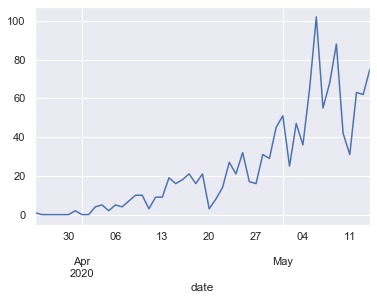

In [132]:
df["deaths_d"].plot()
plt.show()

- Increasing trend of cases over time.
- There do not appears to be systematic seasonality to the cases for each day.
- There do not appear to be any obvious outliers.

### Histogram and Density Plot

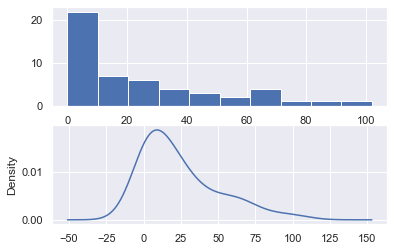

In [133]:
plt.figure(1)
plt.subplot(211)
df["deaths_d"].hist()

plt.subplot(212)
df["deaths_d"].plot(kind='kde')
plt.show()

- The distribution is not Guassian.
- The shape has a long right rail and may suggest an exponential distribution.

### Box and Whisker Plots

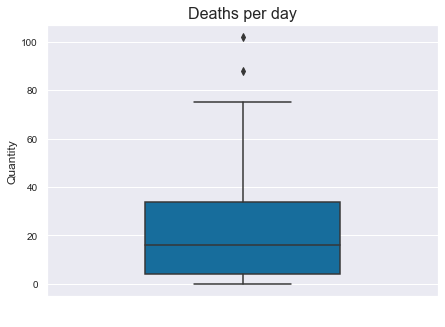

In [134]:
plt.figure(figsize=(7,5))
bplot = sns.boxplot(y='deaths_d', 
                 data=df, 
                 width=0.5,
                 palette="colorblind")

bplot.axes.set_title("Deaths per day", fontsize=16)
bplot.set_xlabel(" ", fontsize=12)
bplot.set_ylabel("Quantity", fontsize=12)
bplot.tick_params(labelsize=10)

- There are outliers on the top.

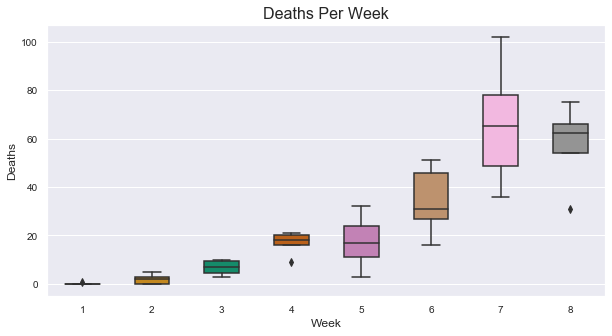

In [135]:
plt.figure(figsize=(10,5))
bplot = sns.boxplot(y='deaths_d', x='week', data=df,
                    width=0.5, palette="colorblind")

bplot.axes.set_title("Deaths Per Week", fontsize=16)
bplot.set_xlabel("Week", fontsize=12)
bplot.set_ylabel("Deaths", fontsize=12)
bplot.tick_params(labelsize=10)

# output file name
#plot_file_name="boxplot.jpg"
 
# save as jpeg
#bplot.figure.savefig(plot_file_name, format='jpeg', dpi=100)

### Heat Maps

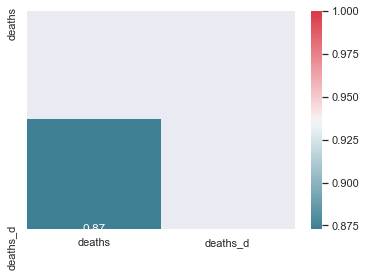

In [136]:
# Analysing correlations

corr = df[["deaths", "deaths_d"]].corr()
fig, ax = plt.subplots(figsize=(6, 4))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.set()
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)

plt.show()

### Lag Scatter Plots

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


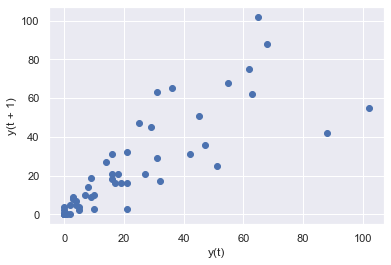

In [137]:
from pandas.plotting import lag_plot
lag_plot(df["deaths_d"])
plt.show()

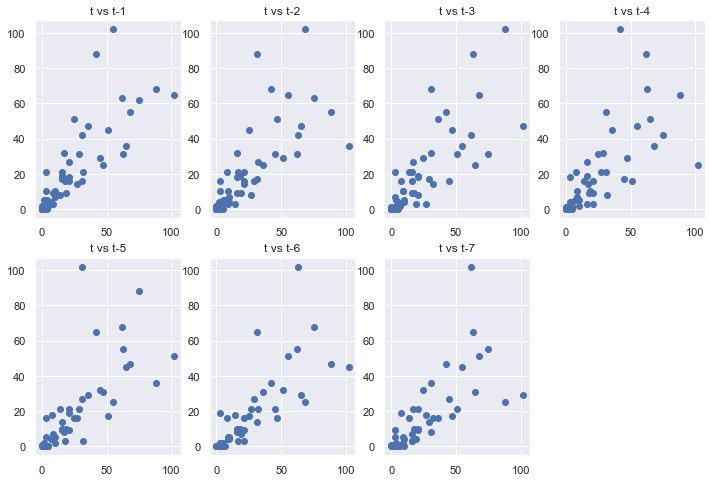

In [138]:
from pandas import concat

lags = 7
columns = [df["deaths_d"]]

for i in range(1,(lags + 1)):
    columns.append(df["deaths_d"].shift(i))

dataframe = concat(columns, axis=1) 
columns = ['t']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i)) 

dataframe.columns = columns 
plt.figure(1, figsize=(12, 8))

for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
plt.show()

### Correlation

In [139]:
values =  pd.DataFrame(df["deaths_d"])
dataframe = concat([values.shift(1), values], axis=1) 
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
print(result)

            t       t+1
t    1.000000  0.816177
t+1  0.816177  1.000000


### Autocorrelation

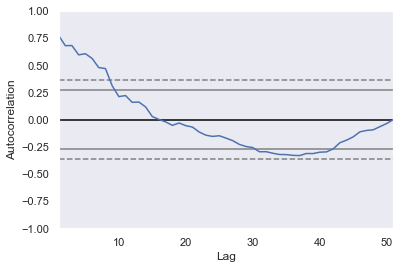

In [140]:
# autocorrelation
autocorrelation_plot(df["deaths_d"])
plt.show()

### Resampling

Two types of resampling are:

- Upsampling: Where you increase the frequency of the samples, such as from minutes to seconds.

- Downsampling: Where you decrease the frequency of the samples, such as from days to months.

There are perhaps two main reasons why you may be interested in resampling your time series data:

- 􏰀Problem Framing: Resampling may be required if your data is available at the same frequency that you want to make predictions.

- Feature Engineering: Resampling can also be used to provide additional structure or insight into the learning problem for supervised learning models.

p.53

In [141]:
df.head(2)

,deaths,day_of_week,day_of_week_n,month,day,deaths_d,week
date,,,,,,,
2020-03-25,1,Wednesday,2,3,25,1.0,1
2020-03-26,1,Thursday,3,3,26,0.0,1


In [142]:
# visualize downsampling to "week" mean

week_mean = df["deaths_d"].resample('W', level=0).mean()
week_mean

date
2020-03-29     0.200000
2020-04-05     1.857143
2020-04-12     6.857143
2020-04-19    17.142857
2020-04-26    17.428571
2020-05-03    34.857143
2020-05-10    65.142857
2020-05-17    57.750000
Freq: W-SUN, Name: deaths_d, dtype: float64

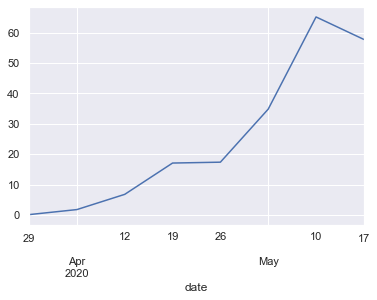

In [143]:
week_mean.plot() 
plt.show()

In [144]:
# week sum

week_sum = df["deaths_d"].resample('W', level=0).sum()
week_sum

date
2020-03-29      1.0
2020-04-05     13.0
2020-04-12     48.0
2020-04-19    120.0
2020-04-26    122.0
2020-05-03    244.0
2020-05-10    456.0
2020-05-17    231.0
Freq: W-SUN, Name: deaths_d, dtype: float64

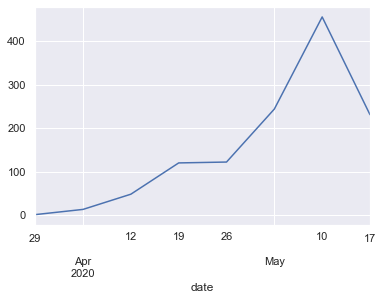

In [145]:
week_sum.plot() 
plt.show()

## Power Transforms

### Quadratic Transform

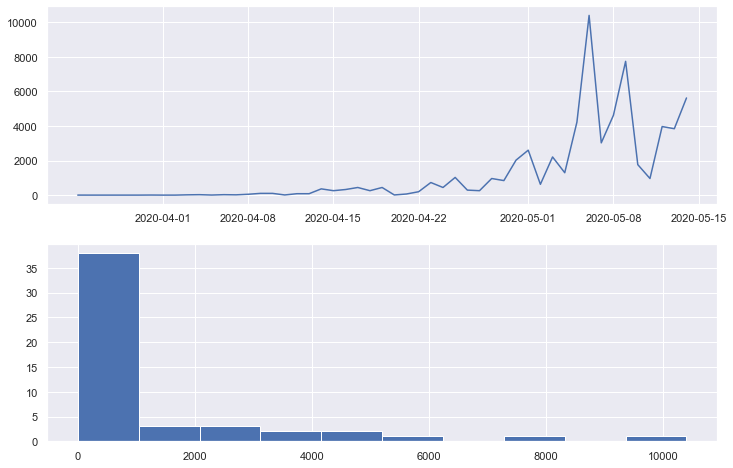

In [146]:
# contrive a quadratic time series

df['deaths_d_quad'] = df['deaths_d']**2
plt.figure(1, figsize=(12, 8))
# line plot
plt.subplot(211) 
plt.plot(df['deaths_d_quad'])
# histogram
plt.subplot(212) 
plt.hist(df['deaths_d_quad'])
plt.show()

### Square Root Transform

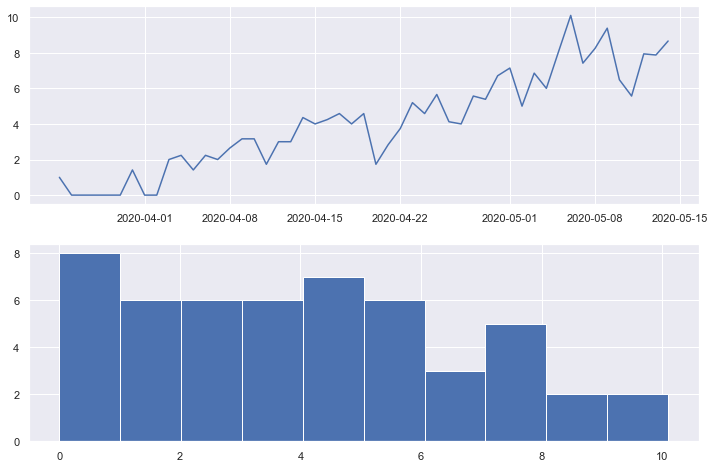

In [147]:
# square root transform a time series

df['deaths_d_sqrt'] = np.sqrt(df['deaths_d']) 
plt.figure(1, figsize=(12, 8))
# line plot
plt.subplot(211) 
plt.plot(df['deaths_d_sqrt'])
# histogram
plt.subplot(212) 
plt.hist(df['deaths_d_sqrt'])
plt.show()

### Exponential Transform

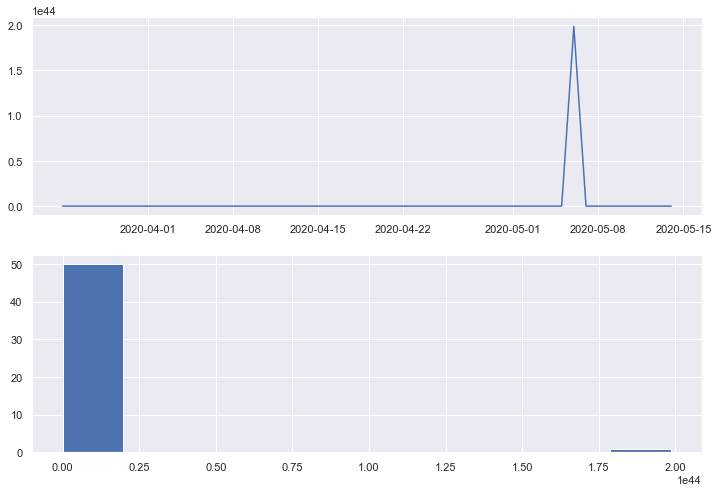

In [148]:
df['deaths_d_exp'] = np.exp(df['deaths_d']) 
plt.figure(1, figsize=(12, 8))
# line plot
plt.subplot(211) 
plt.plot(df['deaths_d_exp'])
# histogram
plt.subplot(212) 
plt.hist(df['deaths_d_exp'])
plt.show()

### Log Transform

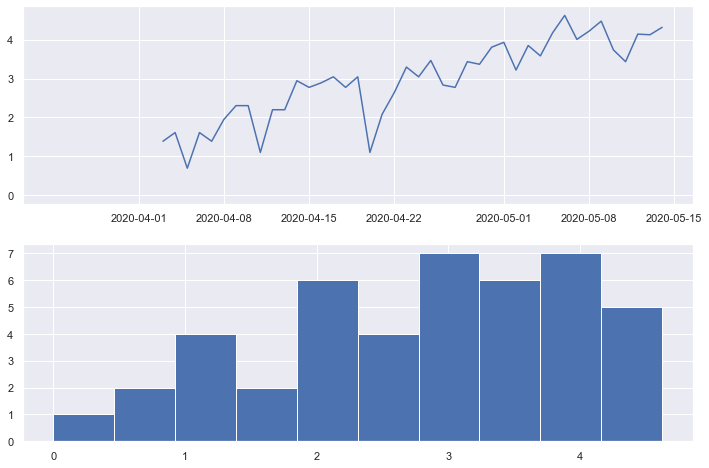

In [149]:
df['deaths_d_log'] = np.log(df['deaths_d']) 
plt.figure(1, figsize=(12, 8))
# line plot
plt.subplot(211) 
plt.plot(df['deaths_d_log'])
# histogram
plt.subplot(212) 
plt.hist(df['deaths_d_log'][np.isfinite(df['deaths_d_log'])].values)
plt.show()

### Box-Cox Transform

Below are some common values for lambda:
􏰀
- lambda = -1. is a reciprocal transform.
􏰀
- lambda = -0.5 is a reciprocal square root transform. 􏰀 lambda = 0.0 is a log transform.
􏰀
- lambda = 0.5 is a square root transform.
􏰀
- lambda = 1.0 is no transform.

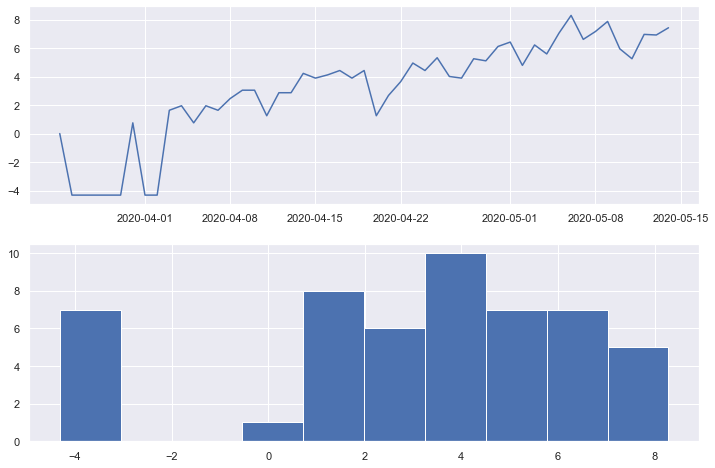

In [150]:
from scipy.stats import boxcox

# boxcox doesn't support zeros
# https://stackoverflow.com/questions/50180988/valueerror-data-must-be-positive-boxcox-scipy

data_positive = df['deaths_d'][df['deaths_d'] > 0]
bcdata, lam = boxcox(data_positive)

df['deaths_d_boxcox'] = df['deaths_d']
df['deaths_d_boxcox'][df['deaths_d'] > 0] = bcdata
df['deaths_d_boxcox'][df['deaths_d'] == 0] = -1/lam

plt.figure(1, figsize=(12, 8))
# line plot
plt.subplot(211) 
plt.plot(df['deaths_d_boxcox'])
# histogram
plt.subplot(212) 
plt.hist(df['deaths_d_boxcox'])
plt.show()

## Moving Average Smoothing

- Centered Moving Average

center_ma(t) = mean(obs(t − 1), obs(t), obs(t + 1))

- Trailing Moving Average

trail_ma(t) = mean(obs(t − 2), obs(t − 1), obs(t))

=> It is assumed that both trend and seasonal components have been removed from your time series.

date
2020-03-25         NaN
2020-03-26         NaN
2020-03-27    0.333333
2020-03-28    0.000000
2020-03-29    0.000000
2020-03-30    0.000000
2020-03-31    0.666667
2020-04-01    0.666667
2020-04-02    0.666667
2020-04-03    1.333333
Name: deaths_d, dtype: float64


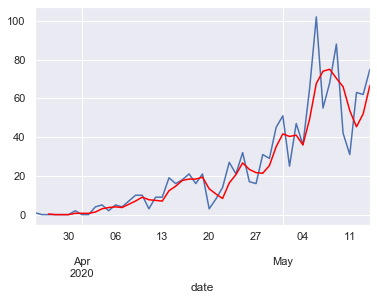

In [151]:
# tail-rolling average transform
rolling = df["deaths_d"].rolling(window=3) 
rolling_mean = rolling.mean() 
print(rolling_mean.head(10))

# plot original and transformed dataset 
df["deaths_d"].plot() 
rolling_mean.plot(color='red') 
plt.show()

## Moving Average as Feature Engineering

In [152]:
width = 3
lag1 = df["deaths_d"].shift(1)
lag3 = df["deaths_d"].shift(width - 1)
window = lag3.rolling(window=width)
means = window.mean()
dataframe = concat([means, lag1, df["deaths_d"]], axis=1) 
dataframe.columns = ['mean', 't', 't+1'] 
print(dataframe.head(10))

                mean    t  t+1
date                          
2020-03-25       NaN  NaN  1.0
2020-03-26       NaN  1.0  0.0
2020-03-27       NaN  0.0  0.0
2020-03-28       NaN  0.0  0.0
2020-03-29  0.333333  0.0  0.0
2020-03-30  0.000000  0.0  0.0
2020-03-31  0.000000  0.0  2.0
2020-04-01  0.000000  2.0  0.0
2020-04-02  0.666667  0.0  0.0
2020-04-03  0.666667  0.0  4.0


## Moving Average as Prediction

In [153]:
# prepare situation
X = df["deaths_d"]

window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)]) 
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

predicted=0.333333, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=2.000000
predicted=0.666667, expected=0.000000
predicted=0.666667, expected=0.000000
predicted=0.666667, expected=4.000000
predicted=1.333333, expected=5.000000
predicted=3.000000, expected=2.000000
predicted=3.666667, expected=5.000000
predicted=4.000000, expected=4.000000
predicted=3.666667, expected=7.000000
predicted=5.333333, expected=10.000000
predicted=7.000000, expected=10.000000
predicted=9.000000, expected=3.000000
predicted=7.666667, expected=9.000000
predicted=7.333333, expected=9.000000
predicted=7.000000, expected=19.000000
predicted=12.333333, expected=16.000000
predicted=14.666667, expected=18.000000
predicted=17.666667, expected=21.000000
predicted=18.333333, expected=16.000000
predicted=18.333333, expected=21.000000
predicted=19.333333, expected=3.000000
predicted=13.333333, expected=8.000000
predicted=10.666667, expected=14.00

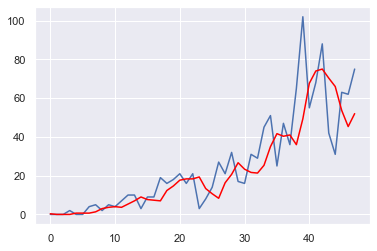

In [154]:
# plot
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

# zoom plot
#pyplot.plot(test[:100]) pyplot.plot(predictions[:100], color='red') pyplot.show()

____
## Temporal Structure

### Is your Time Series White Noise?

### White Noise

- White noise is an important concept in time series forecasting. If a time series is white noise, it is a sequence of random numbers and cannot be predicted.

- A time series may be white noise. A time series is white noise if the variables are independent and identically distributed with a mean of zero. This means that all variables have the same variance (sigma2) and each value has a zero correlation with all other values in the series. If the variables in the series are drawn from a Gaussian distribution, the series is called Gaussian white noise.

- Predictability: If your time series is white noise, then, by definition, it is random. You cannot reasonably model it and make predictions.

- Model Diagnostics: The series of errors from a time series forecast model should ideally be white noise.

Is your Time Series White Noise?
Your time series is not white noise if any of the following conditions are true:
- Does your series have a non-zero mean?
- Does the variance change over time?
- Do values correlate with lag values?

Some tools that you can use to check if your time series is white noise are:
- Create a line plot. Check for gross features like a changing mean, variance, or obvious relationship between lagged variables.
- Calculate summary statistics. Check the mean and variance of the whole series against the mean and variance of meaningful contiguous blocks of values in the series (e.g. days, months, or years).
- Create an autocorrelation plot. Check for gross correlation between lagged variables.


count     51.000000
mean      24.215686
std       25.469443
min        0.000000
25%        4.000000
50%       16.000000
75%       34.000000
max      102.000000
Name: deaths_d, dtype: float64


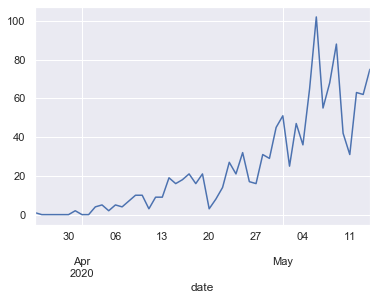

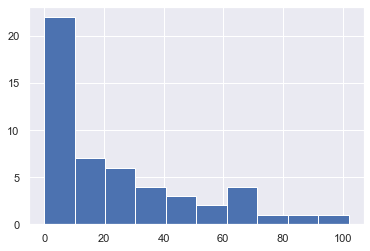

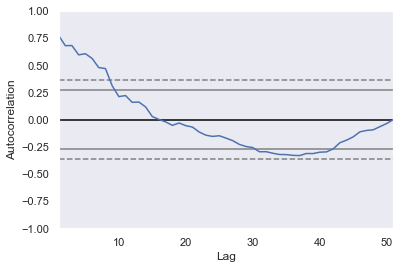

In [155]:
# summary stats
print(df["deaths_d"].describe())

# line plot
df["deaths_d"].plot()
plt.show()

# histogram plot
df["deaths_d"].hist()
plt.show()

# autocorrelation
autocorrelation_plot(df["deaths_d"])
plt.show()

### Check Stationarity

### Augmented Dickey-Fuller test

We can expect a random walk to be non-stationary. In fact, all random walk processes are non-stationary. Note that not all non-stationary time series are random walks. Additionally, a non-stationary time series does not have a consistent mean and/or variance over time. A review of the random walk line plot might suggest this to be the case. We can confirm this using a statistical significance test.


In [156]:
from statsmodels.tsa.stattools import adfuller

# The null hypothesis of the test is that the time series is non-stationary.
# https://machinelearningmastery.com/time-series-data-stationary-python/
# https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test

# statistical test
result = adfuller(df["deaths_d"]) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.168672
p-value: 0.942154
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


The Augmented Dickey-Fuller test is a type of statistical test called a unit root test1. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
􏰀
- Null Hypothesis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
􏰀
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we accept the null hypothesis (non-stationary).
􏰀
- p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.
􏰀
- p-value ≤ 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

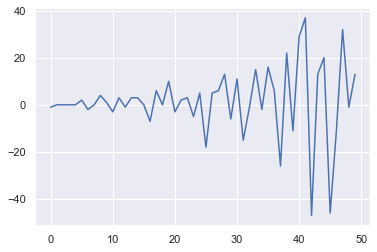

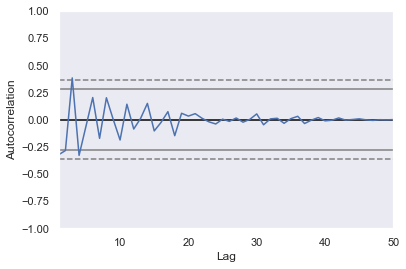

In [157]:
# take difference

X = df["deaths_d"]

diff = list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)

# line plot
plt.plot(diff)
plt.show()

autocorrelation_plot(diff)
plt.show()

In [158]:
# statistical test for diff

result = adfuller(diff) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.075660
p-value: 0.000016
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


Random Walk: Given the way that the random walk is constructed, we would expect a strong autocorrelation with the previous observation and a linear fall off from there with previous lag values. 

Persistence, or the naive forecast, is the best prediction we can make for a random walk time series.

This last point is key for time series forecasting. Baseline forecasts with the persistence model quickly flesh out whether you can do significantly better. If you can’t, you’re probably working with a random walk. Many time series are random walks, particularly those of security prices over time. The random walk hypothesis is a theory that stock market prices are a random walk and cannot be predicted.

## Decompose Time Series Data

### Time Series Components

Systematic Components:
- Level
- Trend
- Seasonality

Nos-Systematic Component:
- Noise


### Combining Time Series Components

A series is thought to be an aggregate or combination of these four components. All series have a level and noise. The trend and seasonality components are optional. It is helpful to think of the components as combining either additively or multiplicatively.

### Automatic Time Series Decomposition

### Additive Decomposition

In [159]:
from statsmodels.tsa.seasonal import seasonal_decompose 

X = df["deaths_d"]

result = seasonal_decompose(X, model='additive') 

print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

date
2020-03-25          NaN
2020-03-26          NaN
2020-03-27          NaN
2020-03-28     0.428571
2020-03-29     0.285714
2020-03-30     0.285714
2020-03-31     0.857143
2020-04-01     1.571429
2020-04-02     1.857143
2020-04-03     2.571429
2020-04-04     2.857143
2020-04-05     3.857143
2020-04-06     5.285714
2020-04-07     6.142857
2020-04-08     5.857143
2020-04-09     6.857143
2020-04-10     7.428571
2020-04-11     9.571429
2020-04-12    10.857143
2020-04-13    12.000000
2020-04-14    13.571429
2020-04-15    15.428571
2020-04-16    17.142857
2020-04-17    16.285714
2020-04-18    14.714286
2020-04-19    14.428571
2020-04-20    15.714286
2020-04-21    15.714286
2020-04-22    18.000000
2020-04-23    17.428571
2020-04-24    19.285714
2020-04-25    22.571429
2020-04-26    24.714286
2020-04-27    27.285714
2020-04-28    31.571429
2020-04-29    30.571429
2020-04-30    34.857143
2020-05-01    37.714286
2020-05-02    42.571429
2020-05-03    53.000000
2020-05-04    54.428571
2020-05-05 

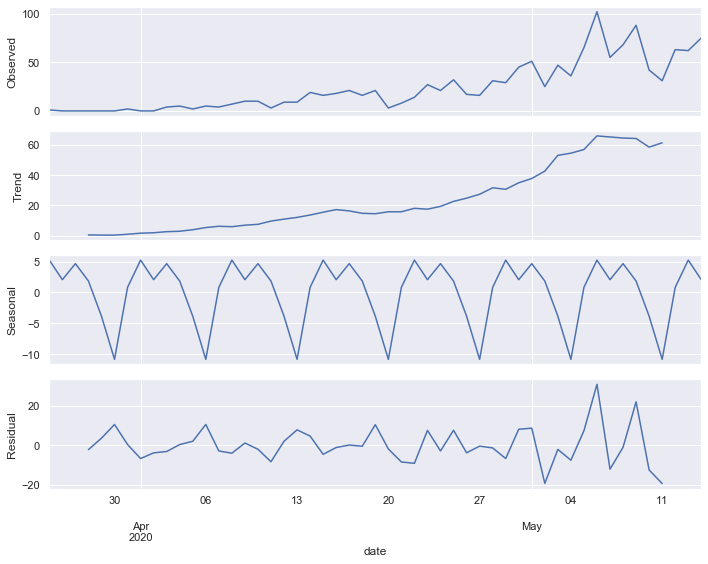

In [160]:
plt.rc("figure", figsize=(10, 8))
result.plot()
plt.show()

### Multiplicative Decomposition

In [161]:
# zero is not permitted

result = seasonal_decompose(X[X>0], model='multiplicative', freq=1) 

print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

date
2020-03-25      1.0
2020-03-31      2.0
2020-04-03      4.0
2020-04-04      5.0
2020-04-05      2.0
2020-04-06      5.0
2020-04-07      4.0
2020-04-08      7.0
2020-04-09     10.0
2020-04-10     10.0
2020-04-11      3.0
2020-04-12      9.0
2020-04-13      9.0
2020-04-14     19.0
2020-04-15     16.0
2020-04-16     18.0
2020-04-17     21.0
2020-04-18     16.0
2020-04-19     21.0
2020-04-20      3.0
2020-04-21      8.0
2020-04-22     14.0
2020-04-23     27.0
2020-04-24     21.0
2020-04-25     32.0
2020-04-26     17.0
2020-04-27     16.0
2020-04-28     31.0
2020-04-29     29.0
2020-04-30     45.0
2020-05-01     51.0
2020-05-02     25.0
2020-05-03     47.0
2020-05-04     36.0
2020-05-05     65.0
2020-05-06    102.0
2020-05-07     55.0
2020-05-08     68.0
2020-05-09     88.0
2020-05-10     42.0
2020-05-11     31.0
2020-05-12     63.0
2020-05-13     62.0
2020-05-14     75.0
Name: deaths_d, dtype: float64
date
2020-03-25    1.0
2020-03-31    1.0
2020-04-03    1.0
2020-04-04    1.0
2020-04

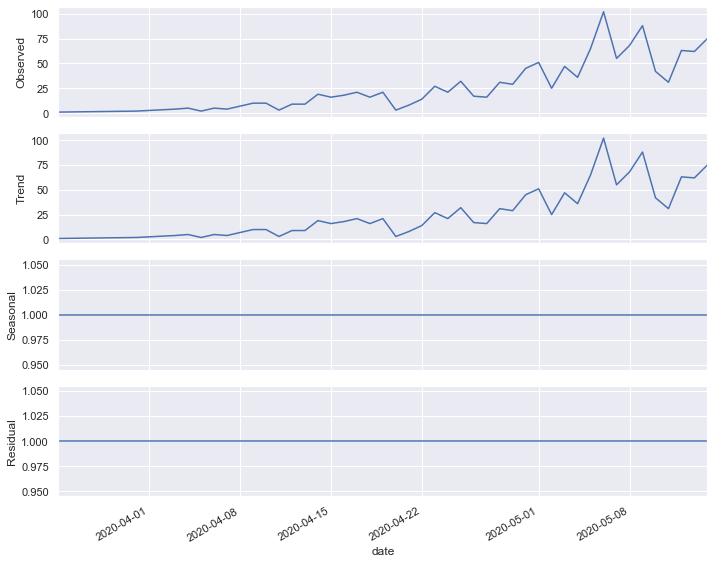

In [162]:
result.plot()
plt.show()

## Use and Remove Trends

Identifying and understanding trend information can aid in improving model performance;
below are a few reasons:
- Faster Modeling: Perhaps the knowledge of a trend or lack of a trend can suggest methods and make model selection and evaluation more efficient.
- Simpler Problem: Perhaps we can correct or remove the trend to simplify modeling and improve model performance.
- More Data: Perhaps we can use trend information, directly or as a summary, to provide additional information to the model and improve model performance.


### Types of Trends

There are all kinds of trends. Two general classes that we may think about are:
- Deterministic Trends: These are trends that consistently increase or decrease. 􏰀 
- Stochastic Trends: These are trends that increase and decrease inconsistently.
In general, deterministic trends are easier to identify and remove, but the methods discussed in this tutorial can still be useful for stochastic trends. We can think about trends in terms of their scope of observations.
􏰀
- Global Trends: These are trends that apply to the whole time series.
- Local Trends: These are trends that apply to parts or subsequences of a time series. 
Generally, global trends are easier to identify and address.


### Detrend by Differencing

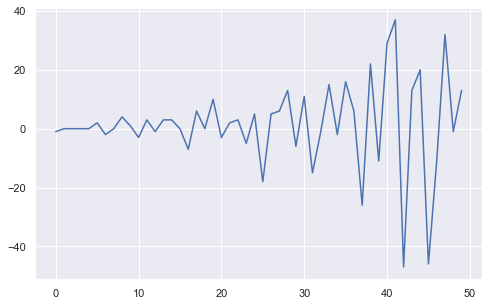

In [163]:
diff = list()
for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)
plt.rc("figure", figsize=(8, 5))
plt.plot(diff)
plt.show()

In [165]:
result = adfuller(diff) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.075660
p-value: 0.000016
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


### Detrend by Model Fitting

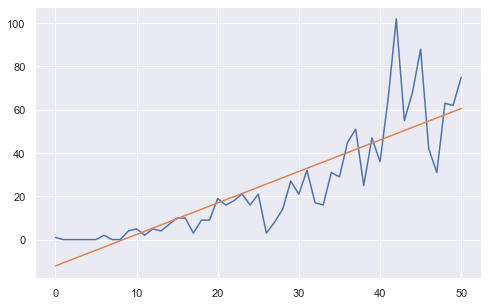

Detrended


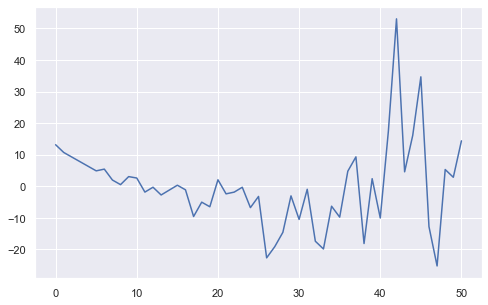

In [83]:
from sklearn.linear_model import LinearRegression


#series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)

series = df["deaths_d"]

# fit linear model
X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values

model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)

# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()

# detrend
detrended = [y[i]-trend[i] for i in range(0, len(series))]

# plot detrended
print("Detrended")
plt.plot(detrended)
plt.show()

In [84]:
result = adfuller(detrended) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.235018
p-value: 0.193782
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


## Use and Remove Seasonality

Understanding the seasonal component in time series can improve the performance of modeling with machine learning. This can happen in two main ways:

- Clearer Signal: Identifying and removing the seasonal component from the time series can result in a clearer relationship between input and output variables.
- More Information: Additional information about the seasonal component of the time series can provide new information to improve model performance.

Both approaches may be useful on a project. Modeling seasonality and removing it from the time series may occur during data cleaning and preparation. Extracting seasonal information and providing it as input features, either directly or in summary form, may occur during feature extraction and feature engineering activities.

Types:
- Time of Day.
- Daily.
- Weekly.
- Monthly.
- Yearly.

### Seasonal Adjustment with Differencing

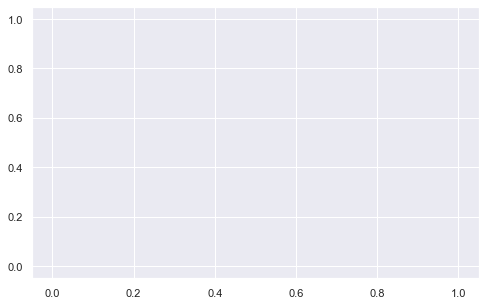

In [85]:
# p.121

X = df["deaths_d"]

diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
    value = X[i] - X[i - days_in_year]
    diff.append(value)
plt.plot(diff)
plt.show()

### Seasonal Adjustment with Modeling

Coefficients: [-2.76596152e-04  5.17529928e-02 -5.05830059e-01  2.11917116e+00]


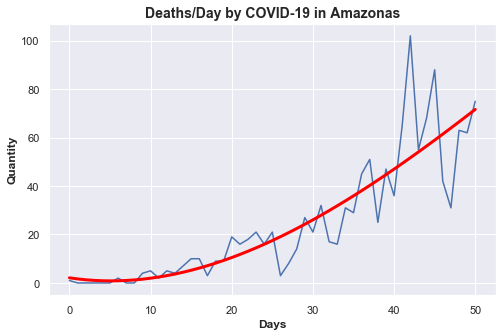

In [86]:
from numpy import polyfit

series = df["deaths_d"]

# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%365 for i in range(0, len(series))] 
y = series.values

degree = 3
coef = polyfit(X, y, degree) 
print('Coefficients: %s' % coef)

# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

# plot curve over original data
plt.plot(series.values) 
plt.plot(curve, color='red', linewidth=3) 
plt.title('Deaths/Day by COVID-19 in Amazonas', weight='bold', size=14)
plt.ylabel('Quantity', weight='bold', size=12)
plt.xlabel('Days', weight='bold', size=12)
plt.show()

In [87]:
# original series
result = adfuller(series) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.168672
p-value: 0.942154
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


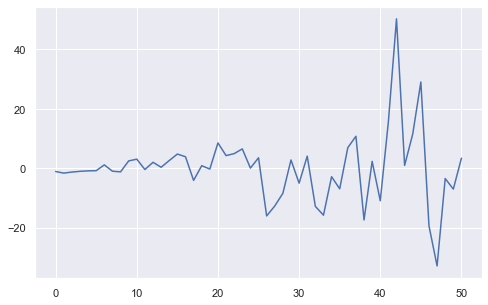

In [88]:
# create seasonally adjusted
values = series.values
diff = list()
for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)
plt.plot(diff)
plt.show()

In [89]:
result = adfuller(diff) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.599936
p-value: 0.000129
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


# Backtest Forecast Models

## Evaluate Models

In time series forecasting, this evaluation of models on historical data is called backtesting.

Three types of backtesting:
1. Train-Test split that respect temporal order of observations.
2. Multiple Train-Test splits that respect temporal order of observations.
3. Walk-Forward Validation where a model may be updated each time step new data is received.


## Train-Test Split

Observations: 51
Training Observations: 33
Testing Observations: 18


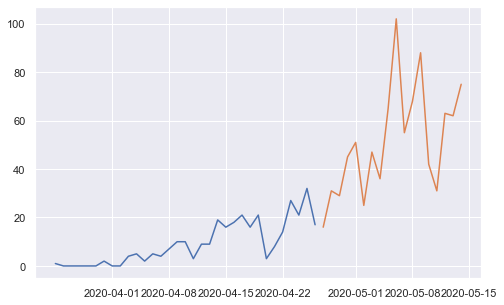

In [90]:
# calculate a train-test split of a time series dataset

X = df["deaths_d"]

split = 0.66

train_size = int(len(X) * split)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

# plot train-test split of time series data
plt.plot(train)
#plt.plot([None for i in train] + [x for x in test])
plt.plot(test)
plt.show()

## Multiple Train-Test Splits

Observations: 27
Training Observations: 15
Testing Observations: 12
Observations: 39
Training Observations: 27
Testing Observations: 12
Observations: 51
Training Observations: 39
Testing Observations: 12


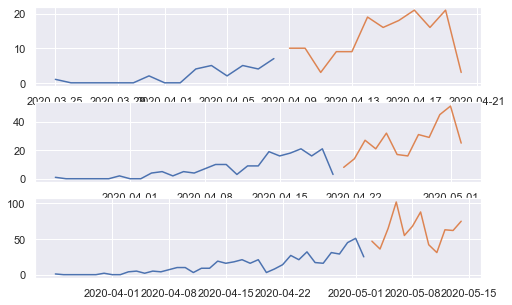

In [91]:
# calculate repeated train-test splits of time series data
from sklearn.model_selection import TimeSeriesSplit

splits = TimeSeriesSplit(n_splits=3)
plt.figure(1)
index = 1

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test))) 
    print('Training Observations: %d' % (len(train))) 
    print('Testing Observations: %d' % (len(test))) 
    plt.subplot(310 + index)
    plt.plot(train)
    #plt.plot([None for i in train] + [x for x in test]) 
    plt.plot(test)
    index += 1
plt.show()

## Walk Forward Validation


In [92]:
n_train = round(len(X) * 0.6)
n_records = len(X)
for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))

train=31, test=1
train=32, test=1
train=33, test=1
train=34, test=1
train=35, test=1
train=36, test=1
train=37, test=1
train=38, test=1
train=39, test=1
train=40, test=1
train=41, test=1
train=42, test=1
train=43, test=1
train=44, test=1
train=45, test=1
train=46, test=1
train=47, test=1
train=48, test=1
train=49, test=1
train=50, test=1


# Forecasting Performance Measures

1. Mean Forecast Error (or Forecast Bias)
2. Mean Absolute Error - MAE
3. Mean Squared Error - MSE
4. Root Mean Squared Error - RMSE


# Persistence Model for Forecasting

## Test Harness

### Validation Dataset

In [93]:

split_size = round(len(X) * 0.90)
dataset, validation = X[0:split_size], X[split_size:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation))) 

# save
dataset.to_csv(data_dir+'dataset.csv')
validation.to_csv(data_dir+'validation.csv')

Dataset 46, Validation 5


https://medium.com/@bingobee01/pandas-tricks-and-tips-a7b87c3748ea

## Persistence - Base Line Model

              t  t+1
date                
2020-03-25  NaN  1.0
2020-03-26  1.0  0.0
2020-03-27  0.0  0.0
2020-03-28  0.0  0.0
2020-03-29  0.0  0.0
Test RMSE: 23.830


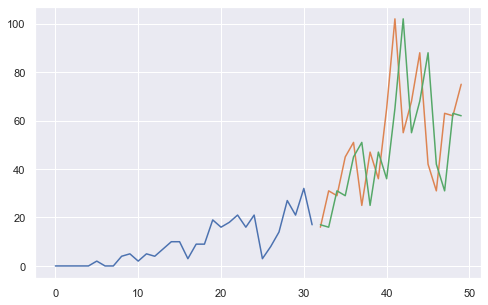

In [95]:
# load data
values = df["deaths_d"]

# create lagged dataset
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1'] 
print(dataframe.head(5))

# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)

train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)

rmse = np.sqrt(mean_squared_error(test_y, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y]) 
plt.plot([None for i in train_y] + [x for x in predictions]) 
plt.show()

# Visualize Residual Forecast Errors

      0
0  -1.0
1  15.0
2  -2.0
3  16.0
4   6.0
               0
count  18.000000
mean    3.222222
std    24.296104
min   -47.000000
25%    -8.750000
50%     9.500000
75%    19.000000
max    37.000000


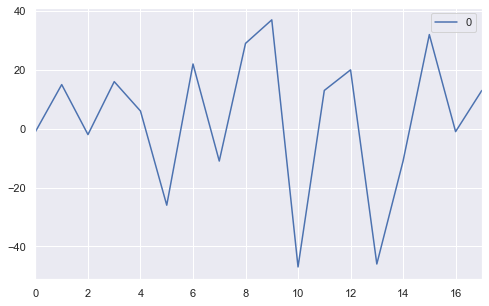

In [96]:
# persistence model
predictions = [x for x in test_X]

# calculate residuals
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))] 
residuals = pd.DataFrame(residuals)
print(residuals.head())

# summary statistics
print(residuals.describe())

# line plot of residual errors
residuals.plot()
plt.show()

## Residual Histogram and Density Plots

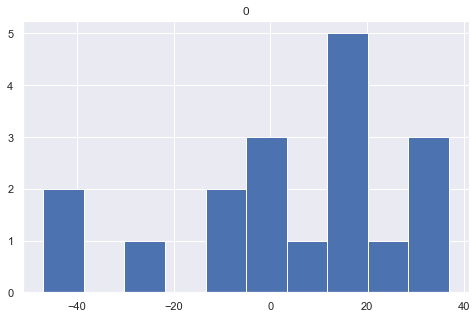

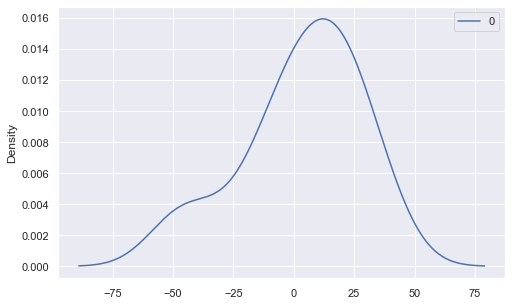

In [97]:
# histogram plot
residuals.hist()
plt.show()

# density plot
residuals.plot(kind='kde')
plt.show()

If the plot showed a distribution that was distinctly non-Gaussian, it would suggest that assumptions made by the modeling process were perhaps incorrect and that a different modeling method may be required. A large skew may suggest the opportunity for performing a transform to the data prior to modeling, such as taking the log or square root.

## Residual Q-Q Plot

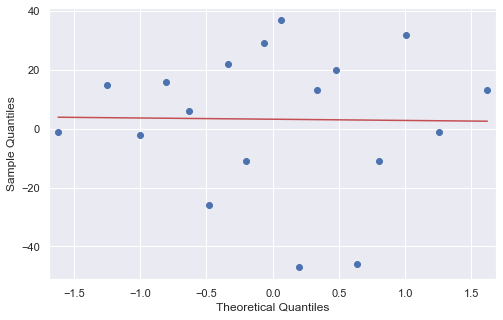

In [98]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='r')
plt.show()

## Residual Autocorrelation Plot

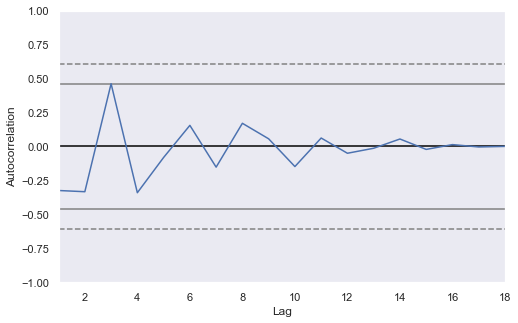

In [99]:
autocorrelation_plot(residuals)
plt.show()

# Reframe Time Series Forecasting Problems

1. How to reframe your time series forecast problem as an alternate regression problem.
2. How to reframe your time series forecast problem as a classification prediction problem. 􏰀 
3. How to reframe your time series forecast problem with an alternate time horizon.

_____
# Forecast Models

## ARIMA - Autoregressive Integrated Moving Average Model

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

Paramenters:
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.


### Configuring AR and MA
Two diagnostic plots can be used to help choose the p and q parameters of the ARMA or ARIMA. They are:
1. Autocorrelation Function (ACF). The plot summarizes the correlation of an obser- vation with lag values. The x-axis shows the lag and the y-axis shows the correlation coefficient between -1 and 1 for negative and positive correlation.
2. Partial Autocorrelation Function (PACF). The plot summarizes the correlations for an observation with lag values that is not accounted for by prior lagged observations.

Both plots are drawn as bar charts showing the 95% and 99% confidence intervals as horizontal lines. Bars that cross these confidence intervals are therefore more significant and worth noting. Some useful patterns you may observe on these plots are:
1. The model is AR if the ACF trails off after a lag and has a hard cut-off in the PACF after a lag. This lag is taken as the value for p.
2. The model is MA if the PACF trails off after a lag and has a hard cut-off in the ACF after the lag. This lag value is taken as the value for q.
3. 􏰀The model is a mix of AR and MA if both the ACF and PACF trail off.

## Autoregression Model

[ 1.  0.  0.  0.  0.  0.  2.  0.  0.  4.  5.  2.  5.  4.  7. 10. 10.  3.
  9.  9. 19. 16. 18. 21. 16. 21.  3.  8. 14. 27. 21. 32. 17. 16. 31. 29.
 45. 51.]
[ 25.  47.  36.  65. 102.  55.  68.  88.  42.  31.  63.  62.  75.]
predicted=43.156873, expected=25.000000
predicted=31.391817, expected=47.000000
predicted=43.411219, expected=36.000000
predicted=44.157734, expected=65.000000
predicted=65.233276, expected=102.000000
predicted=88.726345, expected=55.000000
predicted=62.966049, expected=68.000000
predicted=55.541153, expected=88.000000
predicted=73.846024, expected=42.000000
predicted=86.377788, expected=31.000000
predicted=76.339227, expected=63.000000
predicted=45.891943, expected=62.000000
predicted=98.769836, expected=75.000000
Test RMSE: 27.336


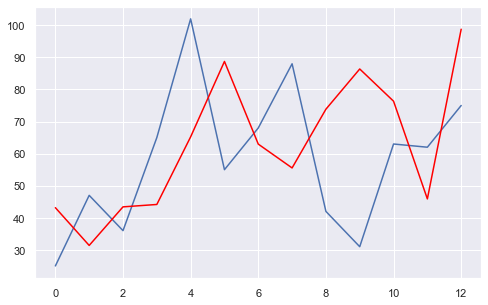

In [102]:
from statsmodels.tsa.ar_model import AR

X = df["deaths_d"].values

# split dataset
split = 0.75

train_size = int(len(X) * split)
train, test = X[0:train_size], X[train_size:len(X)]
print(train)
print(test)

# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot results
plt.plot(test) 
plt.plot(predictions, color='red') 
plt.show()

# Moving Average (MA) Models for Forecasting

## Autoregression of Residual Error

predicted error=12.498316, expected error=-1.000000
predicted error=4.851244, expected error=15.000000
predicted error=-23.402342, expected error=-2.000000
predicted error=-6.665939, expected error=16.000000
predicted error=-14.938950, expected error=6.000000
predicted error=-13.968220, expected error=-26.000000
predicted error=9.096438, expected error=22.000000
predicted error=-14.027647, expected error=-11.000000
predicted error=-10.674187, expected error=29.000000
predicted error=-30.361616, expected error=37.000000
predicted error=-46.548653, expected error=-47.000000
predicted error=-5.263042, expected error=13.000000
predicted error=-18.324061, expected error=20.000000
predicted error=-32.847851, expected error=-46.000000
predicted error=12.045343, expected error=-11.000000
predicted error=2.221910, expected error=32.000000
predicted error=-43.133605, expected error=-1.000000
predicted error=54.287201, expected error=13.000000


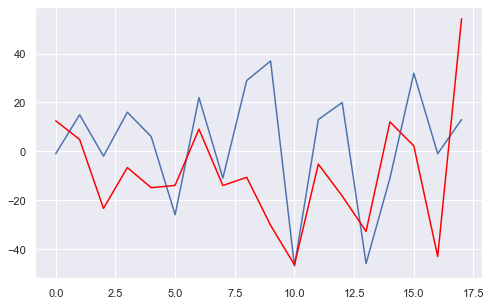

In [104]:
# create lagged dataset
X = df["deaths_d"].values

values = pd.DataFrame(X)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model on training set
train_pred = [x for x in train_X]
    
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))] 

# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    print('predicted error=%f, expected error=%f' % (pred_error, error))

# plot predicted error
plt.plot(expected_error) 
plt.plot(predictions, color='red') 
plt.show()

## Correct Predictions with a Model of Residuals

predicted=29.498316, expected=16.000000
predicted=20.851244, expected=31.000000
predicted=7.597658, expected=29.000000
predicted=22.334061, expected=45.000000
predicted=30.061050, expected=51.000000
predicted=37.031780, expected=25.000000
predicted=34.096438, expected=47.000000
predicted=32.972353, expected=36.000000
predicted=25.325813, expected=65.000000
predicted=34.638384, expected=102.000000
predicted=55.451347, expected=55.000000
predicted=49.736958, expected=68.000000
predicted=49.675939, expected=88.000000
predicted=55.152149, expected=42.000000
predicted=54.045343, expected=31.000000
predicted=33.221910, expected=63.000000
predicted=19.866395, expected=62.000000
predicted=116.287201, expected=75.000000
Test RMSE: 28.868


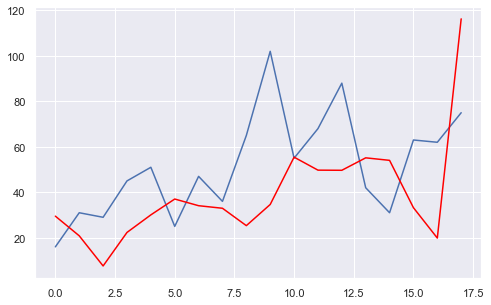

In [105]:
# create lagged dataset

values = df["deaths_d"]
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model on training set
train_pred = [x for x in train_X]
    
# calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))] 

# model the training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
#expected_error = list()
for t in range(len(test_y)):
    
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)
    
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    
    # correct the prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    print('predicted=%f, expected=%f' % (yhat, test_y[t]))

# error
rmse = np.sqrt(mean_squared_error(test_y, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot predicted error
plt.plot(test_y) 
plt.plot(predictions, color='red') 
plt.show()

# ARIMA Model for Forecasting

In [106]:
from statsmodels.tsa.arima_model import ARIMA

X = df["deaths_d"]

- there are high correlations before day 3.

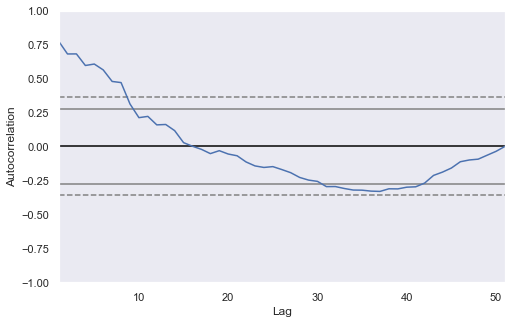

In [107]:
 # autocorrelation plot
autocorrelation_plot(X)
plt.show()

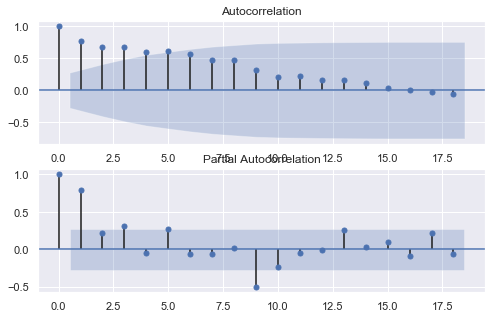

In [108]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(X, ax=plt.gca())
plt.subplot(212)
plot_pacf(X, ax=plt.gca())
plt.show()

# p.219

In [109]:
# ARIMA
p = 2   # Autocorrelation Function (ACF)

d = 1   # level of differencing

q = 0   # Partial Autocorrelation Function (PACF)

                             ARIMA Model Results                              
Dep. Variable:             D.deaths_d   No. Observations:                   50
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -198.709
Method:                       css-mle   S.D. of innovations             12.809
Date:                Fri, 15 May 2020   AIC                            405.417
Time:                        18:58:35   BIC                            413.066
Sample:                    03-26-2020   HQIC                           408.330
                         - 05-14-2020                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.4109      0.973      1.450      0.154      -0.497       3.318
ar.L1.D.deaths_d    -0.4624      0.127     -3.640      0.001      -0.711      -0.213
ar.L2.D.deaths_d    -0.4254 

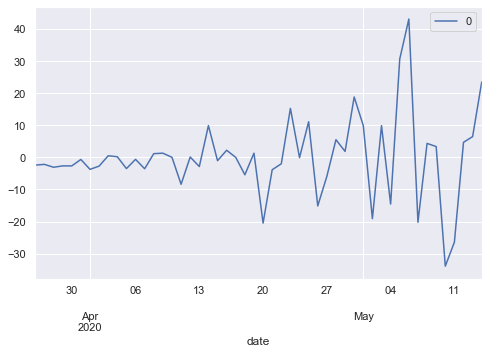

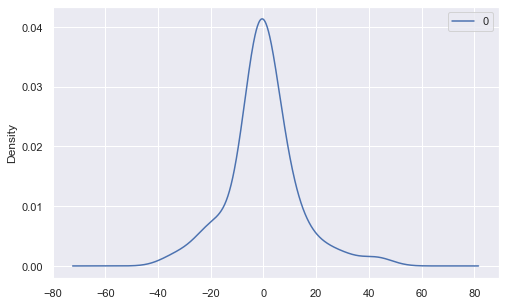

               0
count  50.000000
mean   -0.048157
std    12.940662
min   -33.885546
25%    -3.539130
50%    -0.362637
75%     4.095200
max    43.067468


In [110]:
# fit model
model = ARIMA(X, order=(p,d,q))
model_fit = model.fit(disp=0)

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()
plt.show()

# density plot of residuals residuals.plot(kind='kde') 
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

Note, that although above we used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model.

### Grid Search ARIMA Hyperparameters

ARIMA(0, 0, 0) RMSE=43.358
ARIMA(0, 0, 1) RMSE=31.101
ARIMA(0, 0, 2) RMSE=33.632
ARIMA(0, 1, 0) RMSE=25.185
ARIMA(0, 1, 1) RMSE=24.877
ARIMA(0, 1, 2) RMSE=27.723
ARIMA(0, 2, 0) RMSE=40.968
ARIMA(0, 2, 1) RMSE=25.858
ARIMA(1, 0, 0) RMSE=25.999
ARIMA(1, 1, 0) RMSE=25.663
ARIMA(1, 1, 1) RMSE=25.548
ARIMA(1, 2, 0) RMSE=36.509
ARIMA(1, 2, 1) RMSE=26.333
ARIMA(2, 0, 0) RMSE=25.940
ARIMA(2, 1, 0) RMSE=24.287
ARIMA(2, 2, 0) RMSE=28.025
ARIMA(2, 2, 1) RMSE=28.082
ARIMA(3, 0, 0) RMSE=25.121
ARIMA(3, 1, 0) RMSE=25.228
ARIMA(3, 1, 1) RMSE=25.643
ARIMA(3, 2, 0) RMSE=29.875
ARIMA(3, 2, 1) RMSE=29.337
ARIMA(4, 0, 0) RMSE=26.001
ARIMA(4, 1, 0) RMSE=25.961
ARIMA(4, 2, 0) RMSE=31.831
ARIMA(5, 0, 0) RMSE=27.459
ARIMA(5, 1, 0) RMSE=26.234
ARIMA(5, 2, 0) RMSE=29.130
ARIMA(7, 1, 0) RMSE=28.071
Best ARIMA(2, 1, 0) RMSE=24.287


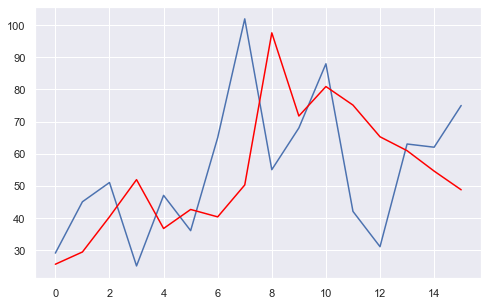

In [172]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_arima_model(X, arima_order): # prepare training dataset
    #X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse, test, predictions

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values): 
    #dataset = dataset.astype('float32')
    best_score, best_cfg, best_test, best_predictions = float("inf"), None, None, None
    for p in p_values:
        for d in d_values:
             for q in q_values:
                order = (p,d,q)
                try:
                    rmse, test, predictions = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                        best_predictions = predictions
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
    # plot forecasts against actual outcomes 
    plt.plot(test)
    plt.plot(best_predictions, color='red') 
    plt.show()

# load dataset
#series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True) # evaluate parameters
p_values = range(0, 10)
d_values = range(0, 4)
q_values = range(0, 4)



X = df["deaths_d"].values

evaluate_models(X, p_values, d_values, q_values)